In [2]:
import os
import cv2
import numpy as np
import sys
import copy
import matplotlib.pyplot as plt
import pickle as pkl
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
#root = '/media/dataset_access/datasets/musohu/bags_03112023_xx_dc_night_1_neutral_0/'
#bp = '/media/dataset_access/go2nus/temp/terrace_new_11_with_overhead_2025-04-08_12-39-55_6_corrected_merged/_0/'
bp = '/media/shashank/T/go2nus/deck_1_without_overhead_2025-03-26_12-05-52_1_corrected_merged_0/'
start = 92
end = 94
img_paths = [f'{i}.jpg' for i in range(start,end)]
imgs = [cv2.imread(os.path.join(bp, 'imgs',img_path),cv2.IMREAD_COLOR_RGB) for img_path in img_paths]
lidars = [np.load(os.path.join(bp,'pcd', img_name.replace('.jpg','.npz')))['arr_0'] for img_name in img_paths]
if os.path.exists(os.path.join(bp,'tracks.pkl')):
    tracks = np.load(os.path.join(bp,'tracks.pkl'),allow_pickle=True)
if os.path.exists(os.path.join(bp,'traj_data.pkl')):
    trajs = np.load(os.path.join(bp,'traj_data.pkl'),allow_pickle=True)
with open(os.path.join(bp,'pedestrians_3d.pkl'),'rb') as f:
    pedestrians = pkl.load(f)
#lidar to camera transformation

In [3]:
def get_color(idx):
    idx = idx * 3
    color = ((37 * idx) % 255, (17 * idx) % 255, (29 * idx) % 255)
    return color

def plot_tracking(image, tlwhs, obj_ids, scores=None, frame_id=0, fps=0., ids2=None):
    im = np.ascontiguousarray(np.copy(image))
    im_h, im_w = im.shape[:2]

    top_view = np.zeros([im_w, im_w, 3], dtype=np.uint8) + 255

    #text_scale = max(1, image.shape[1] / 1600.)
    #text_thickness = 2
    #line_thickness = max(1, int(image.shape[1] / 500.))
    text_scale = 2
    text_thickness = 2
    line_thickness = 3

    radius = max(5, int(im_w/140.))
    cv2.putText(im, 'frame: %d fps: %.2f num: %d' % (frame_id, fps, len(tlwhs)),
                (0, int(15 * text_scale)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=2)

    for i, tlwh in enumerate(tlwhs):
        x1, y1, w, h = tlwh
        intbox = tuple(map(int, (x1, y1, x1 + w, y1 + h)))
        obj_id = int(obj_ids[i])
        bbxar = w*h*100.0/(im_w*im_h)
        print(f'BBX area: {obj_id}: {w*h}/{im_w*im_h} = {bbxar}')
        if bbxar<1.0:
            continue
        id_text = '{}'.format(int(obj_id))
        if ids2 is not None:
            id_text = id_text + ', {}'.format(int(ids2[i]))
        color = get_color(abs(obj_id))
        cv2.rectangle(im, intbox[0:2], intbox[2:4], color=color, thickness=line_thickness)
        area_ratio = w * h * 100.0/ (im_w * im_h)
        cv2.putText(im, f'{obj_id}_{area_ratio:.2f}', (intbox[0], intbox[1]), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                    thickness=text_thickness)
        
    return im

BBX area: 28152: 6768.0/407040 = 1.6627358490566038
BBX area: 28214: 10878.0/407040 = 2.6724646226415096
BBX area: 28202: 46009.0/407040 = 11.303311713836479
BBX area: 28211: 36332.0/407040 = 8.925904088050315
BBX area: 28218: 12136.0/407040 = 2.9815251572327046
BBX area: 28215: 9280.0/407040 = 2.279874213836478
BBX area: 28219: 15336.0/407040 = 3.767688679245283
BBX area: 28202: 47260.0/407040 = 11.61065251572327
BBX area: 28211: 37820.0/407040 = 9.291470125786164
BBX area: 28218: 13695.0/407040 = 3.3645341981132075
BBX area: 28215: 8835.0/407040 = 2.1705483490566038
BBX area: 28219: 14214.0/407040 = 3.4920400943396226
BBX area: 28196: 12876.0/407040 = 3.1633254716981134
BBX area: 28213: 13923.0/407040 = 3.4205483490566038
BBX area: 28220: 27250.0/407040 = 6.694673742138365
BBX area: 28152: 7150.0/407040 = 1.7565841194968554


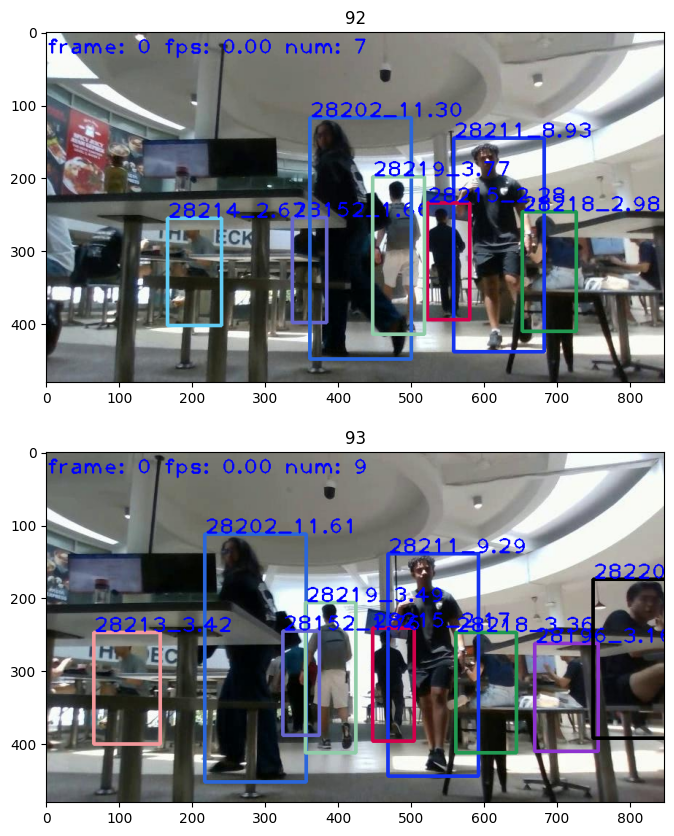

In [4]:
ax, fig = plt.subplots(end-start,1,figsize = (10,5*(end-start)))
for i in range(start,end):
    if tracks[i][0] is None:
        print(f'No tracking for {i}')
    else:
        #fig[i-start].imshow(plot_tracking(imgs[i-start],tracks[i][0],tracks[i][1]))
        fig[i-start].imshow(plot_tracking(imgs[i-start],tracks[i][0],tracks[i][1]))
        fig[i-start].set_title(f'{i}')

In [5]:
# find the robot's orientation corresponding to the sensor reading
position = trajs['position'][start]
orientation = trajs[''][start]

KeyError: ''

In [7]:
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [8]:
vis.delete()

In [15]:
vis[f'scene_{0}\pc'].set_object(
        g.PointsGeometry(
            lidars[0].T,
            color = np.zeros_like(lidars[0].T),  
        ),
        g.PointsMaterial(size=0.04)
    )
for j,t in enumerate(range(start,end)):
    peds_3d = pedestrians[t]
    # vis[f'scene_{t}\pc'].set_object(
    #     g.PointsGeometry(
    #         lidars[j].T,
    #         color = np.zeros_like(lidars[j].T),  
    #     ),
    #     g.PointsMaterial(size=0.05)
    # )
    for i,p in enumerate(peds_3d):
        color_hex = int('0x{:02x}{:02x}{:02x}'.format(*get_color(p[1])), 16)
        vis[f"scene_{t}/sphere_{i}"].set_object(g.Sphere(0.1), 
                    g.MeshLambertMaterial(
                    color=color_hex,
                    reflectivity=0.8))
        vis[f"scene_{t}/sphere_{i}"].set_transform(tf.translation_matrix(p[0]))
        print(f'{t}:{p}:{p[1]}')
        #p[0][-1] = 0.0
        # vis[f"scene_{t}/peds_{i}"].set_object(
        #     g.PointsGeometry(
        #         p[0].T,
        #         color = (np.ones_like(p[0])*get_color(p[1])/255.0).T,  
        #     ),
        #     g.PointsMaterial(size=0.1)
        # )

92:(array([[ 3.04759838, -0.04718442, -0.17071762]]), 28202):28202
92:(array([[ 3.22719111, -1.05903746, -0.22859845]]), 28211):28211
93:(array([[ 2.45301071,  0.5433289 , -0.13741055]]), 28202):28202
93:(array([[ 3.90902094, -0.70381921, -0.27689594]]), 28211):28211
93:(array([[ 2.59507391, -1.66729523, -0.14964116]]), 28220):28220


In [38]:
with open(os.path.join(bp,'scan.pkl'),'rb') as f:
    scans = pkl.load(f)

In [39]:
scan = scans[start+3]
scan_3d = np.array([[min(100.0,r) * np.cos(-np.pi/2 +theta*0.25*np.pi/180), min(100.0,r) * np.sin(-np.pi/2 +theta*0.25*np.pi/180), 0] for theta, r in enumerate(scan)])

In [44]:
vis[f'scene_{3}\pc'].set_object(
        g.PointsGeometry(
            lidars[3].T,
            color = np.zeros_like(lidars[3].T),  
        ),
        g.PointsMaterial(size=0.05)
    )
vis[f'scene_{0}\scan'].set_object(
        g.PointsGeometry(
            scan_3d.T,
            color = np.ones_like(scan_3d.T),  
        ),
        g.PointsMaterial(size=0.05)
    )

In [34]:
from IPython.display import Video

# Convert sequence of images into a video
video_path = 'output_video.mp4'
frame_height, frame_width, _ = imgs[0].shape
out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 4, (frame_width, frame_height))

for img in imgs:
    out.write(img)
out.release()

In [ ]:
sys.path.append('../../anonymization-bag/scripts/')
from byte_track_wrapper import ByteTrackWrapper
tracker = ByteTrackWrapper("/home/shashank/code/packages/ByteTrack/pretrained/bytetrack_x_mot17.pth.tar","/home/shashank/code/packages/ByteTrack/exps/example/mot/yolox_x_mix_det.py")
exp_file = '/home/shashank/code/packages/ByteTrack/exps/example/mot/yolox_x_mix_det.py'

width = int(imgs[0].shape[1])
height = int(imgs[0].shape[0])
fps = 4.0
num_frames = len(imgs)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('utown_1_2025-03-07_12-41-18_9_img_tracked.mp4', fourcc, fps, (width, height))
frame_idx = 0

for i,img in enumerate(imgs):
    frame = copy.deepcopy(img)
    # TODO: Here you can add any frame processing you need. 
    save_frame = copy.deepcopy(frame)
    bbox_tlwh, track_ids = tracker.update(frame)
    for box_index in range(len(bbox_tlwh)):
        top_left_x, top_left_y, bb_width, bb_height = bbox_tlwh[box_index]
        x1, y1, x2, y2 = int(top_left_x), int(top_left_y), int(top_left_x + bb_width), int(top_left_y + bb_height)
    frame_idx += 1
    print(f"Processed frame {frame_idx}/{num_frames}", end='\r', flush=True)
    out.write(plot_tracking(save_frame, bbox_tlwh, track_ids))
out.release()